In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point
import geodatasets as gd
import plotly.graph_objects as go

1. 分布和路线可视化
(1) 总仓(Changshu)- 分仓

In [2]:
nodes = pd.read_csv('../data/nodes.csv')
ship_tot2sub = pd.read_csv('../data/ship_tot2sub.csv')
warehouses = pd.read_csv('../data/warehouses.csv')['warehouse_name'].tolist()
origin = warehouses[0]
rdcs   = warehouses[1:]

nodes['category'] = nodes['node_id'].apply(
    lambda x: 'origin' if x == origin else ('rdc' if x in rdcs else 'other')
)

lines = []
for _, row in ship_tot2sub[ship_tot2sub.source == origin].iterrows():
    if row.dest in rdcs:  # 线路
        src = nodes.loc[nodes.node_id == origin, ['lng','lat']].iloc[0]
        dst = nodes.loc[nodes.node_id == row.dest, ['lng','lat']].iloc[0]
        lines.append({'lon':[src.lng,dst.lng],'lat':[src.lat,dst.lat],'qty':row.qty})

fig = go.Figure()
max_qty = max([l['qty'] for l in lines] + [1])
for i, l in enumerate(lines):
    fig.add_trace(go.Scattermap(
        lon = l['lon'], lat = l['lat'], mode='lines',
        line=dict(width=(l['qty']/max_qty)*10, color='blue'),
        hovertemplate=f"Quantity: {l['qty']}<extra></extra>",
        name='OD', legendgroup='OD', showlegend=(i==0)
    ))

# 节点
rdc_nodes = nodes[nodes.category=='rdc']
fig.add_trace(go.Scattermap(
    lon=rdc_nodes.lng, lat=rdc_nodes.lat, mode='markers',
    marker=dict(size=10,color='orange'),
    name='RDCs', hoverinfo='text', hovertext=rdc_nodes.node_id
))
origin_node = nodes[nodes.category=='origin']
fig.add_trace(go.Scattermap(
    lon=origin_node.lng, lat=origin_node.lat, mode='markers',
    marker=dict(size=14,color='red',symbol='diamond'),
    name='NDC_常熟', hoverinfo='text', hovertext=origin_node.node_id
))

fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_center=dict(lat=nodes.lat.mean(), lon=nodes.lng.mean()),
    mapbox_zoom=4,
    margin=dict(l=0,r=0,t=30,b=0),
    title="NDC → RDC"
)

fig.show()

fig_n2rdc = fig

(2) 分仓-分仓

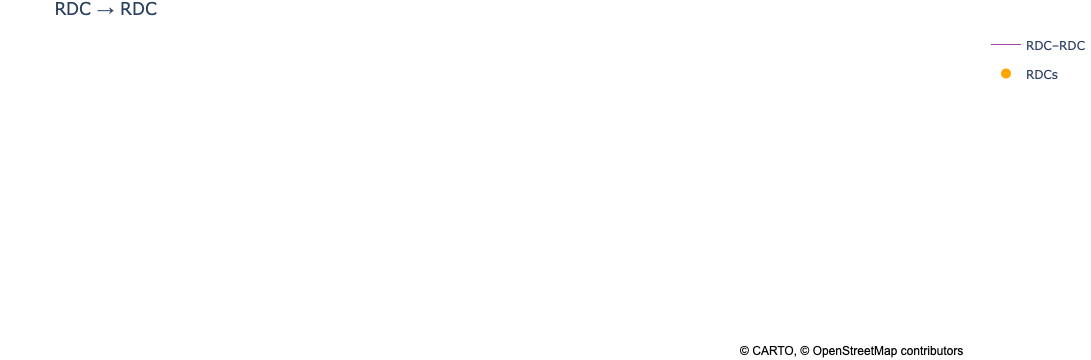

In [7]:
ship_ss    = pd.read_csv('../data/ship_sub2sub.csv')
nodes['category'] = nodes['node_id'].apply(
    lambda x: 'origin' if x == origin else ('rdc' if x in rdcs else 'other')
)
lines = []
for _, row in ship_ss.iterrows():
    src_id, dst_id = row.source, row.dest
    if src_id in rdcs and dst_id in rdcs and src_id != dst_id:
        src = nodes.loc[nodes.node_id == src_id, ['lng','lat']].iloc[0]
        dst = nodes.loc[nodes.node_id == dst_id, ['lng','lat']].iloc[0]
        lines.append({
            'lon': [src.lng, dst.lng],
            'lat': [src.lat, dst.lat],
            'qty': row.qty
        })

fig = go.Figure()
max_qty = max((l['qty'] for l in lines), default=1)
for i, l in enumerate(lines):
    fig.add_trace(go.Scattermap(
        lon = l['lon'],
        lat = l['lat'],
        mode = 'lines',
        line = dict(width = (l['qty']/max_qty)*10, color='purple'),
        hovertemplate = f"Quantity: {l['qty']}<extra></extra>",
        name = 'RDC–RDC',
        legendgroup = 'RDC–RDC',
        showlegend = (i == 0)
    ))

rdc_nodes = nodes[nodes.category=='rdc']
fig.add_trace(go.Scattermap(
    lon = rdc_nodes.lng,
    lat = rdc_nodes.lat,
    mode = 'markers',
    marker = dict(size=10, color='orange'),
    name = 'RDCs',
    hoverinfo = 'text',
    hovertext = rdc_nodes.node_id
))

fig.update_layout(
    mapbox_style  = "carto-positron",
    mapbox_center = dict(lat = nodes.lat.mean(), lon = nodes.lng.mean()),
    mapbox_zoom   = 4,
    margin        = dict(l=0, r=0, t=30, b=0),
    title         = "RDC → RDC"
)
fig.show()

fig_rdc2rdc = fig

3. 分仓-门店

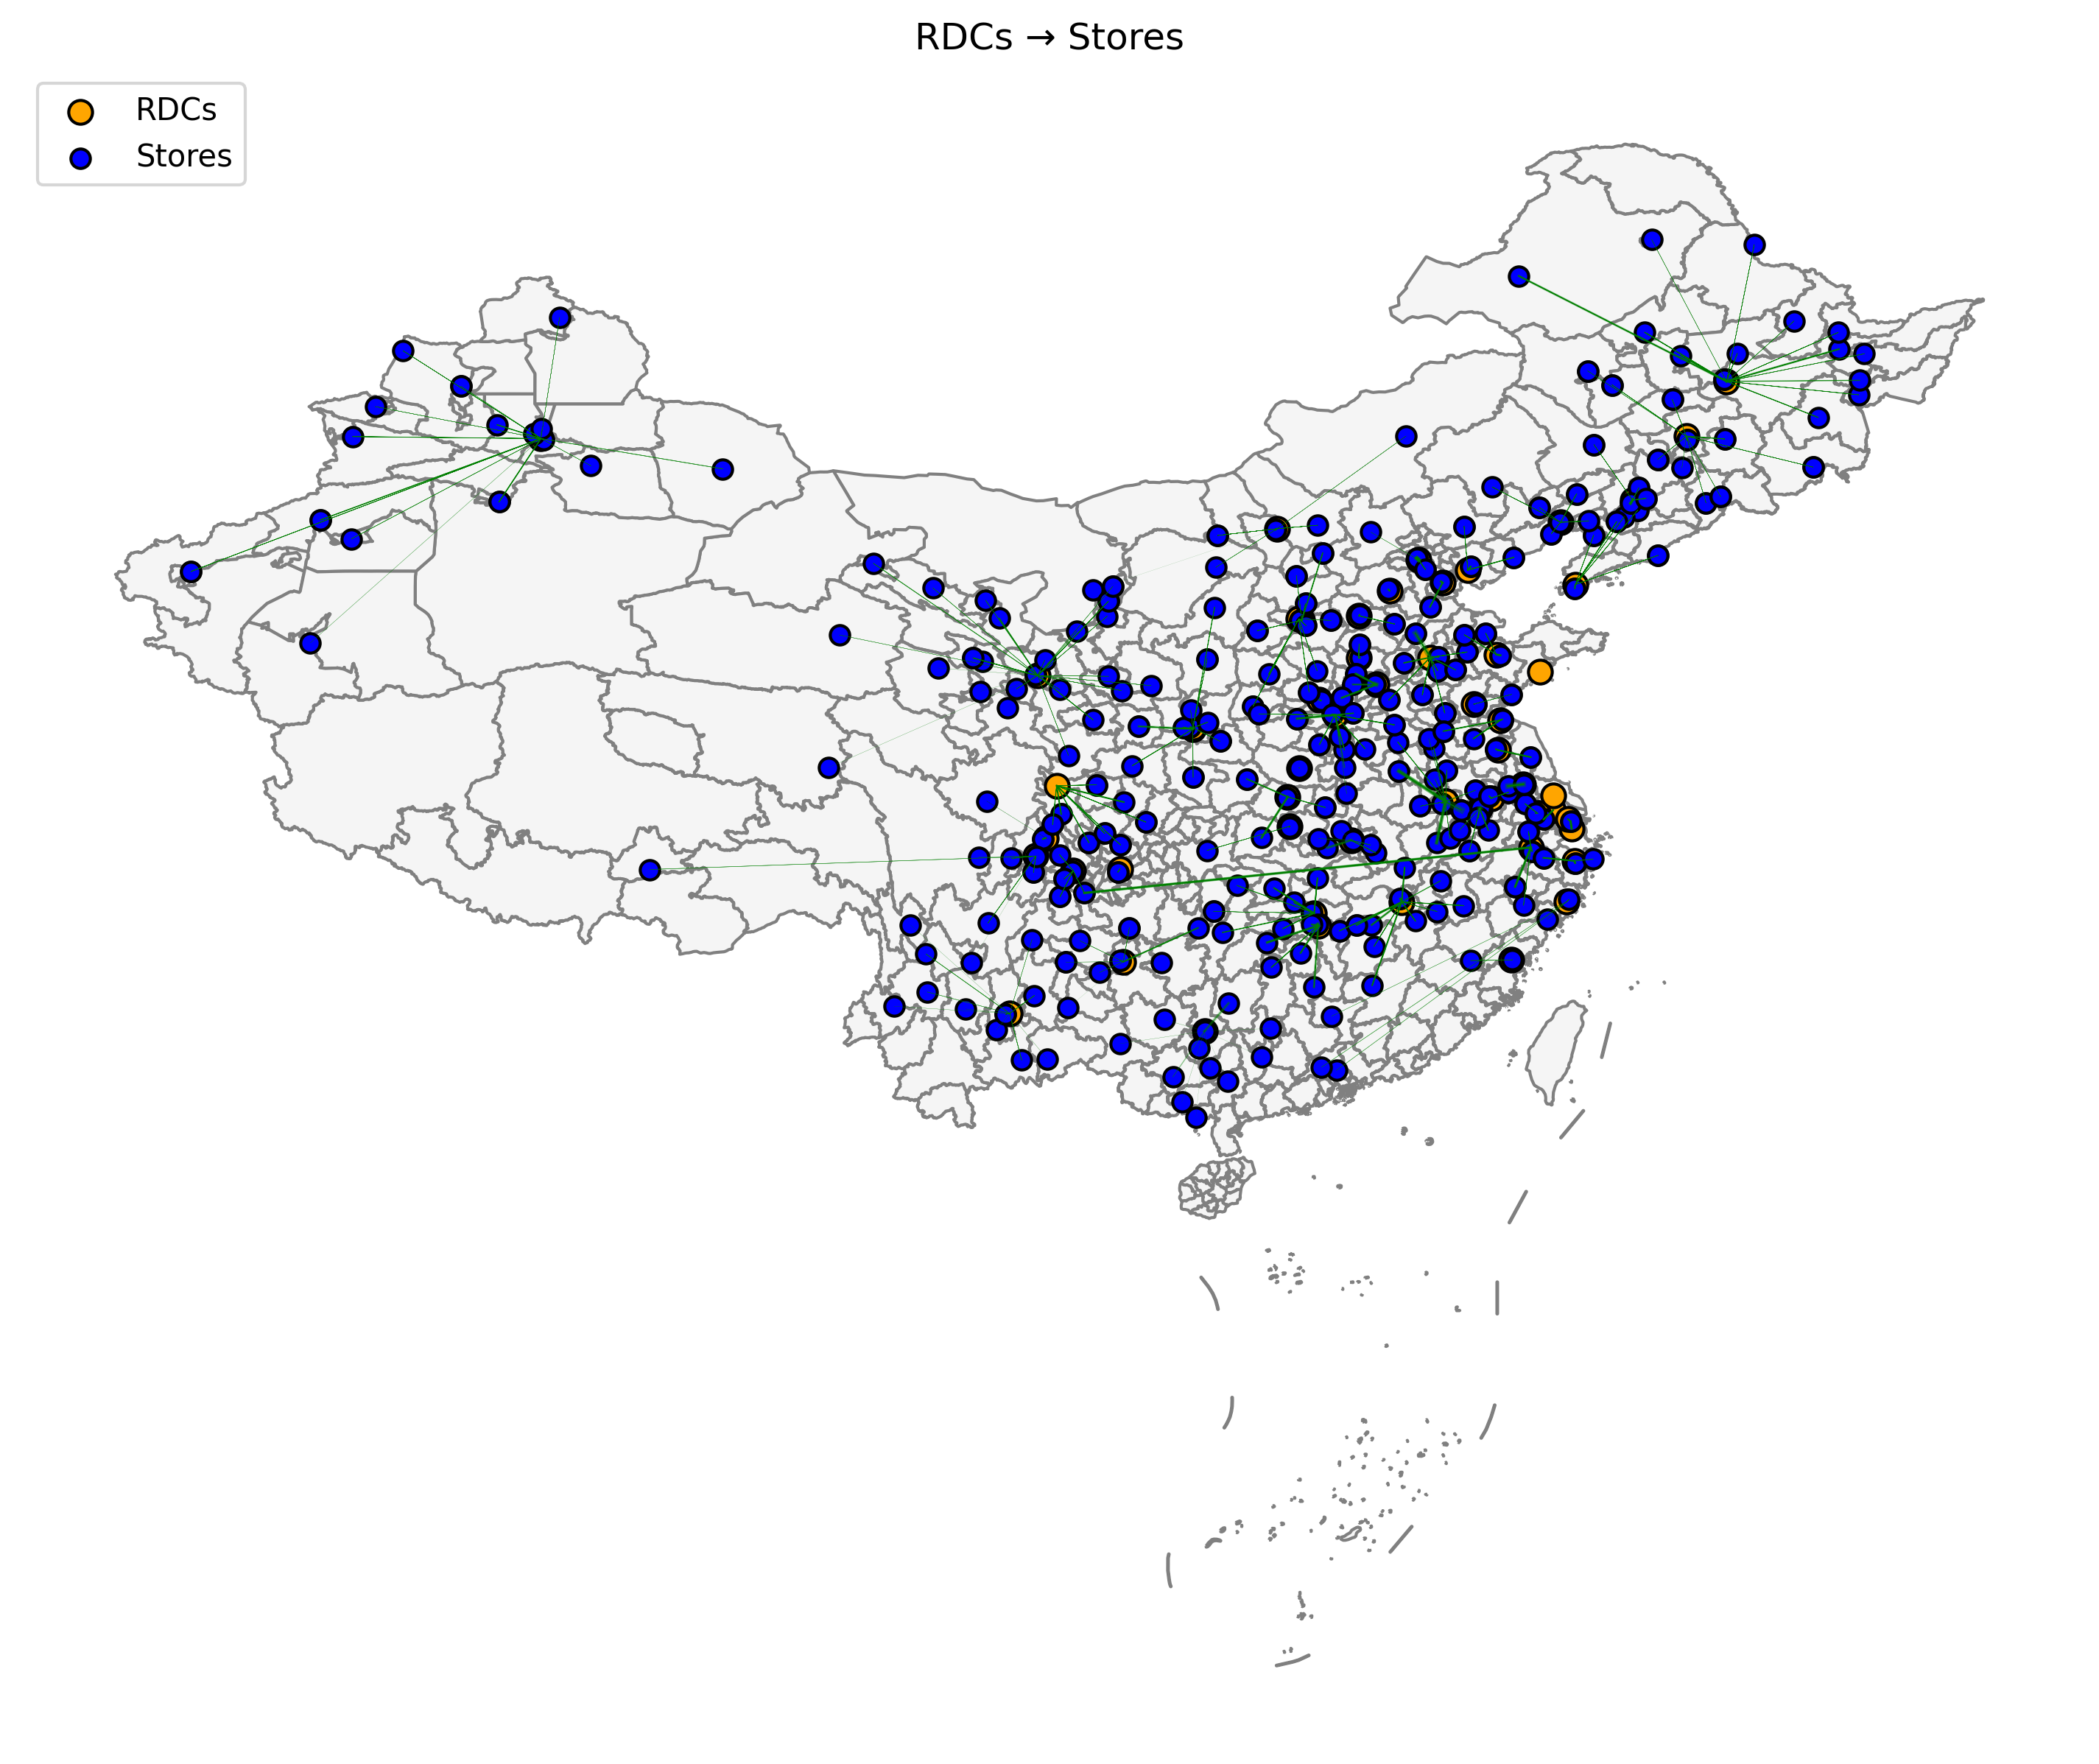

In [8]:
china = gpd.read_file('../map/china.shp')
nodes = pd.read_csv('../data/nodes.csv')
ship_st = pd.read_csv('../data/ship_sub2store.csv')
rdcs = pd.read_csv('../data/warehouses.csv')['warehouse_name'].tolist()[1:]
stores = pd.read_csv('../data/stores.csv')['store_name'].tolist()
def label_node(n):
    if n in rdcs:
        return 'rdc'
    elif n in stores:
        return 'store'
    else:
        return 'other'

nodes['category'] = nodes['node_id'].apply(label_node)
lines = []
for _, row in ship_st.iterrows():
    src_id, dst_id, qty = row.source, row.dest, row.qty
    if src_id in rdcs and dst_id in stores:
        src = nodes.loc[nodes.node_id == src_id, ['lng','lat']].iloc[0]
        dst = nodes.loc[nodes.node_id == dst_id, ['lng','lat']].iloc[0]
        lines.append((src.lng, src.lat, dst.lng, dst.lat, qty))

fig, ax = plt.subplots(figsize=(12, 10),dpi=300)
china.plot(ax=ax, color='whitesmoke', edgecolor='gray')
max_qty = max([qty for *_, qty in lines] + [1])
for lon1, lat1, lon2, lat2, qty in lines:
    lw = (qty / max_qty) * 2  # 线宽比例
    ax.plot([lon1, lon2], [lat1, lat2], color='green', linewidth=lw, alpha=0.4)
rdc_nodes = nodes[nodes.category == 'rdc']
ax.scatter(rdc_nodes.lng, rdc_nodes.lat, s=60, c='orange', label='RDCs', edgecolor='k')
store_nodes = nodes[nodes.category == 'store']
ax.scatter(store_nodes.lng, store_nodes.lat, s=40, c='blue', label='Stores', edgecolor='k')
ax.set_title('RDCs → Stores')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(loc='upper left')
ax.set_aspect('equal')
ax.set_axis_off()

plt.show()

fig_rdc2store = fig